## Описание набора данных

В этом соревновании мы классифицируем распространённые заболевания грудной клетки лёгких и локализуем критические признаки. Это задача на обнаружение и классификацию объектов.

Для каждого тестового изображения вы будете прогнозировать ограничивающую рамку и класс для всех результатов. Если вы прогнозируете отсутствие результатов, следует создать прогноз «14 1 0 0 1 1» (14 — это идентификатор класса, соответствующий отсутствию результатов, что обеспечивает ограничивающую рамку шириной в один пиксель с достоверностью 1,0).

Изображения имеют формат DICOM, что означает, что они содержат дополнительные данные, которые могут быть полезны для визуализации и классификации.

---

### Информация о наборе данных

Набор данных включает **18 000 рентгенограмм грудной клетки** в задне-передней проекции (ПЗП) в формате **DICOM**, которые были деперсонифицированы для защиты конфиденциальности пациентов.  
Все изображения были промаркированы группой опытных рентгенологов на предмет наличия **14 критических рентгенологических признаков**, перечисленных ниже:

- 0 — Aortic enlargement  
- 1 — Atelectasis  
- 2 — Calcification  
- 3 — Cardiomegaly  
- 4 — Consolidation  
- 5 — ILD  
- 6 — Infiltration  
- 7 — Lung Opacity  
- 8 — Nodule/Mass  
- 9 — Other lesion  
- 10 — Pleural effusion  
- 11 — Pleural thickening  
- 12 — Pneumothorax  
- 13 — Pulmonary fibrosis  
- 14 — No finding (отсутствие всех находок)

Наблюдение «Нет результатов» (14) было призвано зафиксировать отсутствие всех указанных выше результатов.  
Обратите внимание, что ключевой частью этого конкурса является работа с данными, полученными от нескольких рентгенологов.

---

### Файлы

- **train.csv** — метаданные тренировочного набора, содержащие по одной строке для каждого объекта, включая класс и ограничивающий прямоугольник.  
  Некоторые изображения как в тестовом, так и в тренировочном наборе содержат несколько объектов.  
- **sample_submission.csv** — файл образца отправки в правильном формате.

---

### Колонки в train.csv

- `image_id` — уникальный идентификатор изображения  
- `class_name` — наименование класса обнаруженного объекта (или «Не обнаружено»)  
- `class_id` — идентификатор класса обнаруженного объекта  
- `rad_id` — удостоверение личности рентгенолога, проводившего наблюдение  
- `x_min` — минимальная координата X ограничивающей рамки объекта  
- `y_min` — минимальная координата Y ограничивающей рамки объекта  
- `x_max` — максимальная координата X ограничивающего прямоугольника объекта  
- `y_max` — максимальная координата Y ограничивающего прямоугольника объекта


DICOM (Digital Imaging and Communications in Medicine) — это медицинский формат изображений, хранящий не только сам пиксельный снимок, но и встроенные метаданные

train.csv
Это основная таблица аннотаций, где каждая строка — это отдельный объект (bounding box) на изображении.
Если на одном снимке несколько находок (например, «Pleural effusion» и «Nodule»), то он встречается несколько раз.

sample_submission.csv
Файл-шаблон для финальной отправки на Kaggle.
Он нужен только чтобы понять формат вывода.

## План анализа данных 

### I. Предобработка данных
- Загрузка `train.csv`
- Проверка пропусков и дубликатов
- Удаление дубликатов и восстановление NaN

---

### II. Общая информация
- Количество уникальных снимков и радиологов
- Среднее, медианное и максимальное число разметок на снимок

---

### III. Анализ классов
- Распределение снимков по классам
- Число уникальных классов на изображение
- Доля редких и частых патологий

---

### IV. Анализ радиологов
- Количество разметок по радиологам
- Heatmap активности радиологов по классам

---

### V. Согласованность разметки
- IoU между рамками радиологов:
  - По радиологу
  - По классу
  - Общая средняя
- Бинарная согласованность (наличие пересечения)
- Визуализация разметок каждого радиолога на отдельном изображении

---

### VI. Зависимости и закономерности
- Частые сочетания диагнозов на снимках
- Корреляция между классами

---

### VII. Выводы для моделирования
- Учёт мультиклассовости
- Стратегии борьбы с дисбалансом
- Основные метрики: Recall, F1, PR-AUC, mAP
- Учёт вариативности разметки и корреляций между патологиями

## Импорты

In [117]:
!pip install pydicom python-gdcm

In [2]:
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.lines import Line2D
from matplotlib.colors import hsv_to_rgb
import seaborn as sns

import pydicom

from tqdm import tqdm # Если долгий анализ, пригодится видеть процент
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

import itertools

## Пути, константы

In [3]:
kagglehub.login()
data_dir = kagglehub.competition_download('vinbigdata-chest-xray-abnormalities-detection') 
train_csv_path = os.path.join(data_dir, "train.csv")
dicom_train_dir = os.path.join(data_dir, "train")

## I. Предобработка данных

In [6]:
df = pd.read_csv(os.path.join(data_dir, "train.csv"))

pd.set_option("display.max_columns", None)
sns.set(style="whitegrid", font_scale=1.1)

df.head()

image_id          class_name  class_id rad_id  \
0  50a418190bc3fb1ef1633bf9678929b3          No finding        14    R11   
1  21a10246a5ec7af151081d0cd6d65dc9          No finding        14     R7   
2  9a5094b2563a1ef3ff50dc5c7ff71345        Cardiomegaly         3    R10   
3  051132a778e61a86eb147c7c6f564dfe  Aortic enlargement         0    R10   
4  063319de25ce7edb9b1c6b8881290140          No finding        14    R10   

    x_min   y_min   x_max   y_max  
0     NaN     NaN     NaN     NaN  
1     NaN     NaN     NaN     NaN  
2   691.0  1375.0  1653.0  1831.0  
3  1264.0   743.0  1611.0  1019.0  
4     NaN     NaN     NaN     NaN

### Дубликаты и пропуски

In [8]:
# 0
# Пропуски
print("Всего строк в train.csv (разметок) до удаления дубликатов:", len(df))
print("Количество пропусков по столбцам:")
print(df.isna().sum())

df_tmp = df.fillna(-1)
print("Количество дубликатов (с учетом NaN):", df_tmp.duplicated(
    subset=['image_id', 'class_name', 'class_id', 'rad_id', 'x_min', 'y_min', 'x_max', 'y_max']
).sum())
print("Уникальных строк:", len(df_tmp.drop_duplicates(
    subset=['image_id', 'class_name', 'class_id', 'rad_id', 'x_min', 'y_min', 'x_max', 'y_max']
)))

df = (df.fillna(-1)
        .drop_duplicates(subset=['image_id', 'class_name', 'class_id', 'rad_id', 'x_min', 'y_min', 'x_max', 'y_max'])
        .replace(-1, np.nan))

print("Всего строк в train.csv (разметок) после удаления дубликатов:", len(df))


Всего строк в train.csv (разметок) до удаления дубликатов: 67914
Количество пропусков по столбцам:
image_id          0
class_name        0
class_id          0
rad_id            0
x_min         31818
y_min         31818
x_max         31818
y_max         31818
dtype: int64
Количество дубликатов (с учетом NaN): 0
Уникальных строк: 67914
Всего строк в train.csv (разметок) после удаления дубликатов: 67914


## II. Общая информация

Уникальных снимков (image_id): 15000
Уникальных радиологов (rad_id): 17

Среднее количество разметок на снимок: 4.5276
Медиана количества разметок на снимок: 3.0
Максимум количества разметок на одном снимке: 57

Топ-10 изображений по количеству разметок:
image_id
03e6ecfa6f6fb33dfeac6ca4f9b459c9    57
fa109c087e46fe1ea27e48ce6d154d2f    52
e31be972e181987a8600a8700c1ebe88    48
ecf474d5d4f65d7a3e23370a68b8c6a0    46
3a302fbbbf3364aa1a7731b59e6b98ec    46
6d5acf3f8a973a26844d617fffe72998    46
c699f16ba0b86f474390da9515bcad7a    42
d8275cd2eabf34a7f7bf22bdd838bc70    40
498ac0c4815a890629cf509446a47238    39
dfd523a5991fc852654bf1235c6282c6    39
Name: class_id, dtype: int64


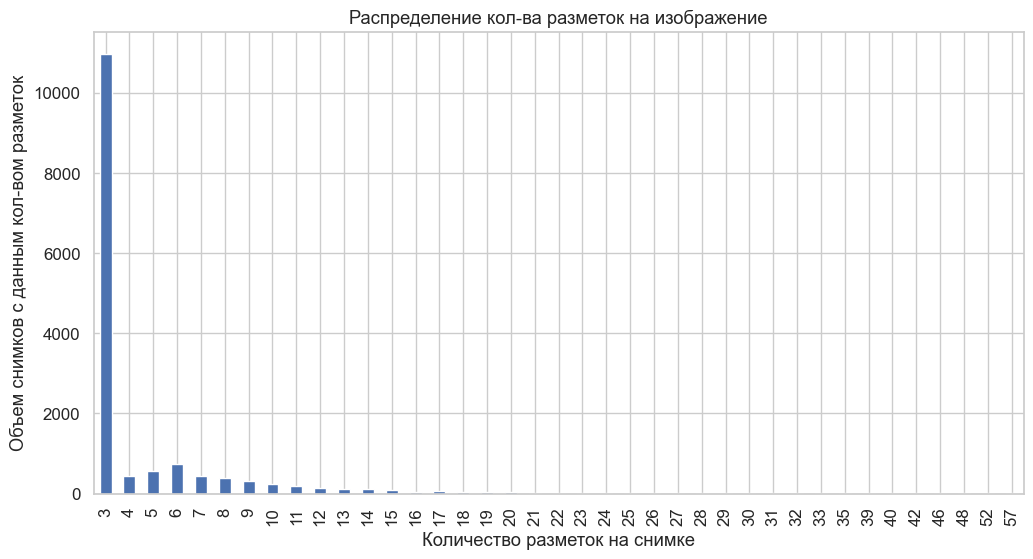

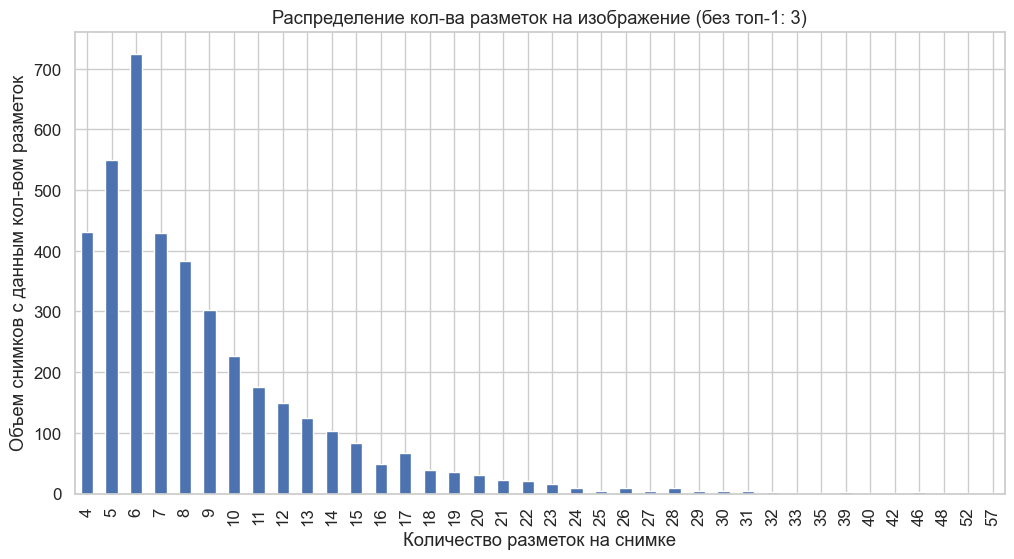

In [14]:
# =========================
# 1. Общее
# =========================
print("Уникальных снимков (image_id):", df["image_id"].nunique())
print("Уникальных радиологов (rad_id):", df["rad_id"].nunique())


# =========================
# 2. Анализ разметки
# =========================

# Группируем по id изображения
groups_by_images_id = df.groupby("image_id")["class_id"].count()
print("\nСреднее количество разметок на снимок:", groups_by_images_id.mean())
print("Медиана количества разметок на снимок:", groups_by_images_id.median())
print("Максимум количества разметок на одном снимке:", groups_by_images_id.max()) # 57 — выпад? (похоже нет)

top10 = groups_by_images_id.sort_values(ascending=False).head(10)
print("\nТоп-10 изображений по количеству разметок:")
print(top10)

# Распределение кол-ва разметок на изображение
plt.figure(figsize=(12,6))
groups_by_images_id.value_counts().sort_index().plot(kind="bar")
plt.xlabel("Количество разметок на снимке")
plt.ylabel("Объем снимков с данным кол-вом разметок")
plt.title("Распределение кол-ва разметок на изображение")
plt.show()

# То же самое без топ-1
counts = groups_by_images_id.value_counts().sort_index()
exclude = counts.sort_values(ascending=False).index[0]  # Индекс самого частого
counts = counts.drop(exclude)

plt.figure(figsize=(12,6))
counts.plot(kind="bar")
plt.xlabel("Количество разметок на снимке")
plt.ylabel("Объем снимков с данным кол-вом разметок")
plt.title(f"Распределение кол-ва разметок на изображение (без топ-1: {exclude})")
plt.show()

## III. Анализ классов

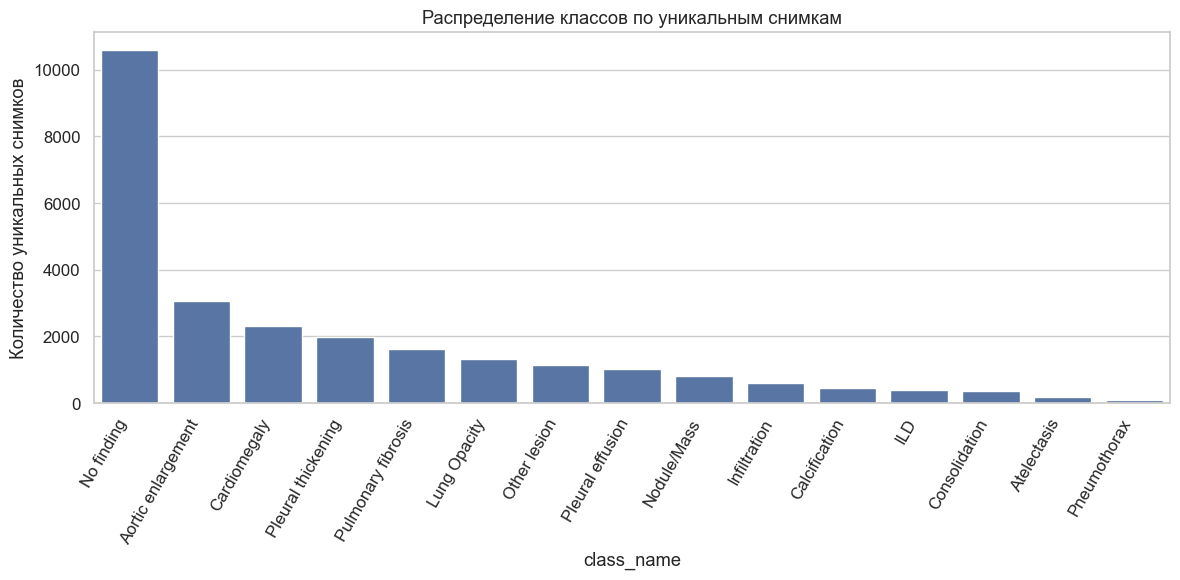

class_name  Количество снимков  Доля, %
0           No finding               10606    40.84
1   Aortic enlargement                3067    11.81
2         Cardiomegaly                2300     8.86
3   Pleural thickening                1981     7.63
4   Pulmonary fibrosis                1617     6.23
5         Lung Opacity                1322     5.09
6         Other lesion                1134     4.37
7     Pleural effusion                1032     3.97
8          Nodule/Mass                 826     3.18
9         Infiltration                 613     2.36
10       Calcification                 452     1.74
11                 ILD                 386     1.49
12       Consolidation                 353     1.36
13         Atelectasis                 186     0.72
14        Pneumothorax                  96     0.37

In [30]:
# =========================
# 1. Сколько уникальных снимков приходится на каждый класс
# =========================

# Считаем количество уникальных снимков на каждый класс
class_counts = df.groupby("class_name")["image_id"].nunique().sort_values(ascending=False)

# График распределения классов по уникальным снимкам
plt.figure(figsize=(12,6))
sns.barplot(
    x=class_counts.index,
    y=class_counts.values
)
plt.xticks(rotation=60, ha="right")
plt.ylabel("Количество уникальных снимков")
plt.title("Распределение классов по уникальным снимкам")
plt.tight_layout()
plt.show()

# Таблица с количеством уникальных снимков и долей
class_table = class_counts.reset_index().rename(columns={"image_id": "Количество снимков"})
class_table = class_table.rename(columns={class_table.columns[1]: "Количество снимков"})
class_table["Доля, %"] = (class_table["Количество снимков"] / class_table["Количество снимков"].sum() * 100).round(2)

# Отсортируем по количеству снимков
class_table = class_table.sort_values("Количество снимков", ascending=False)

display(class_table)

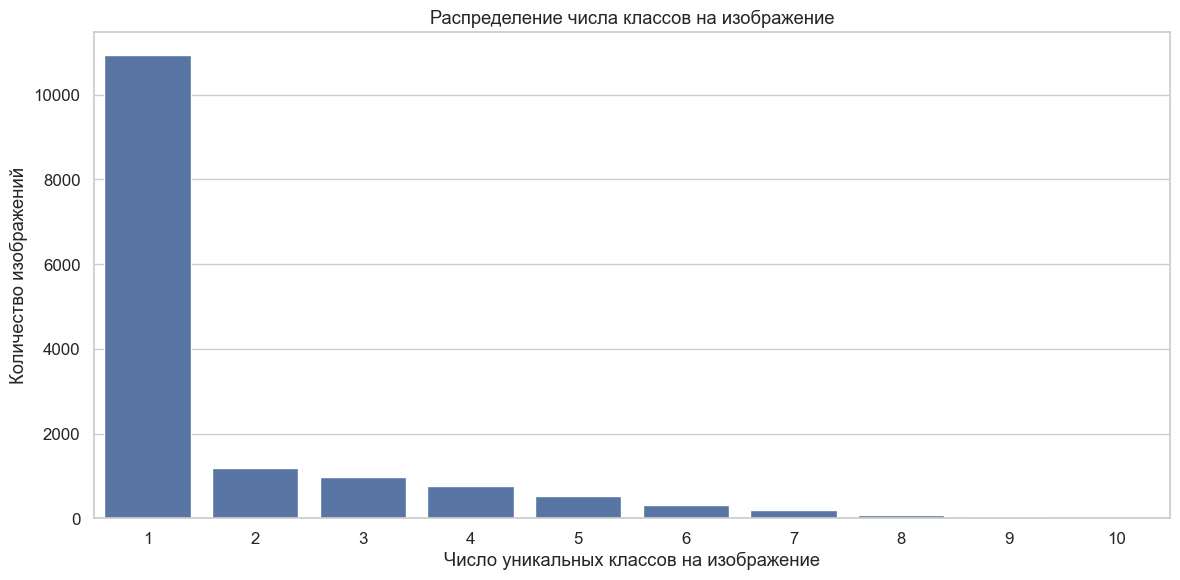

Медиана числа классов на снимок: 1.0
Максимальное число классов на снимок: 10


In [42]:
# =========================
# 2. Сколько уникальных классов приходится на каждый снимок
# =========================

classes_per_image = df.groupby('image_id')['class_name'].nunique()
classes_count = classes_per_image.value_counts().sort_index()

plt.figure(figsize=(12,6))
sns.barplot(
    x=classes_count.index.astype(str),  # числа классов на оси X
    y=classes_count.values
)
plt.xlabel("Число уникальных классов на изображение")
plt.ylabel("Количество изображений")
plt.title("Распределение числа классов на изображение")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Печатаем медиану и максимум
print(f"Медиана числа классов на снимок: {classes_per_image.median()}")
print(f"Максимальное число классов на снимок: {classes_per_image.max()}")

## IV. Анализ радиологов

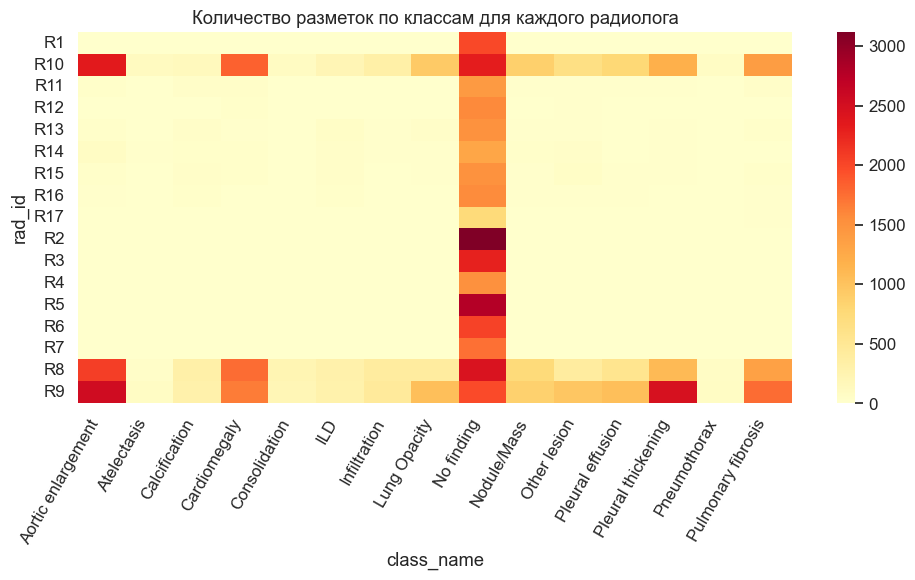

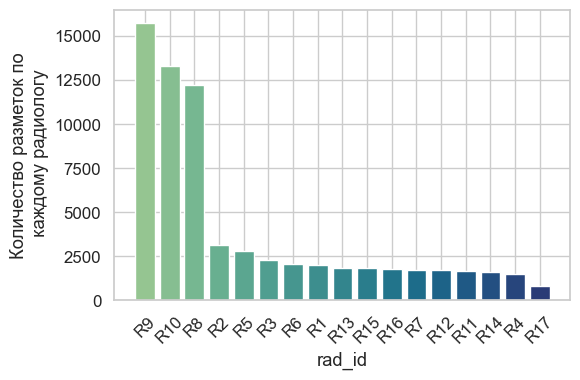

rad_id  Количество разметок  Доля, %
0      R9                15708    23.13
1     R10                13292    19.57
2      R8                12198    17.96
3      R2                 3121     4.60
4      R5                 2783     4.10
5      R3                 2285     3.36
6      R6                 2041     3.01
7      R1                 1995     2.94
8     R13                 1824     2.69
9     R15                 1823     2.68
10    R16                 1763     2.60
11     R7                 1733     2.55
12    R12                 1729     2.55
13    R11                 1670     2.46
14    R14                 1624     2.39
15     R4                 1513     2.23
16    R17                  812     1.20

In [52]:
# =========================
# 1. Анализ количества разметок по радиологам
# =========================

# Сколько раз каждый радиолог ставил каждый класс
rad_class_num = pd.crosstab(df["rad_id"], df["class_name"])

plt.figure(figsize=(10,6))
sns.heatmap(rad_class_num, cmap="YlOrRd", cbar=True)
plt.title("Количество разметок по классам для каждого радиолога")
plt.ylabel("rad_id")
plt.xlabel("class_name")
plt.xticks(rotation=60, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Барплот активности радиологов
plt.figure(figsize=(6,4))
plt.bar(rad_table["rad_id"], rad_table["Количество разметок"], color=sns.color_palette("crest", len(rad_table)))
plt.xlabel("rad_id")
plt.ylabel("Количество разметок по\n каждому радиологу")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Разметки по радиологам
rad_counts = df["rad_id"].value_counts().sort_values(ascending=False)
rad_percent = (rad_counts / rad_counts.sum() * 100).round(2)

rad_table = (
    pd.DataFrame({
        "Количество разметок": rad_counts,
        "Доля, %": rad_percent
    })
    .reset_index()
    .rename(columns={"index": "rad_id"})
)

display(rad_table)

## V. Согласованность разметки

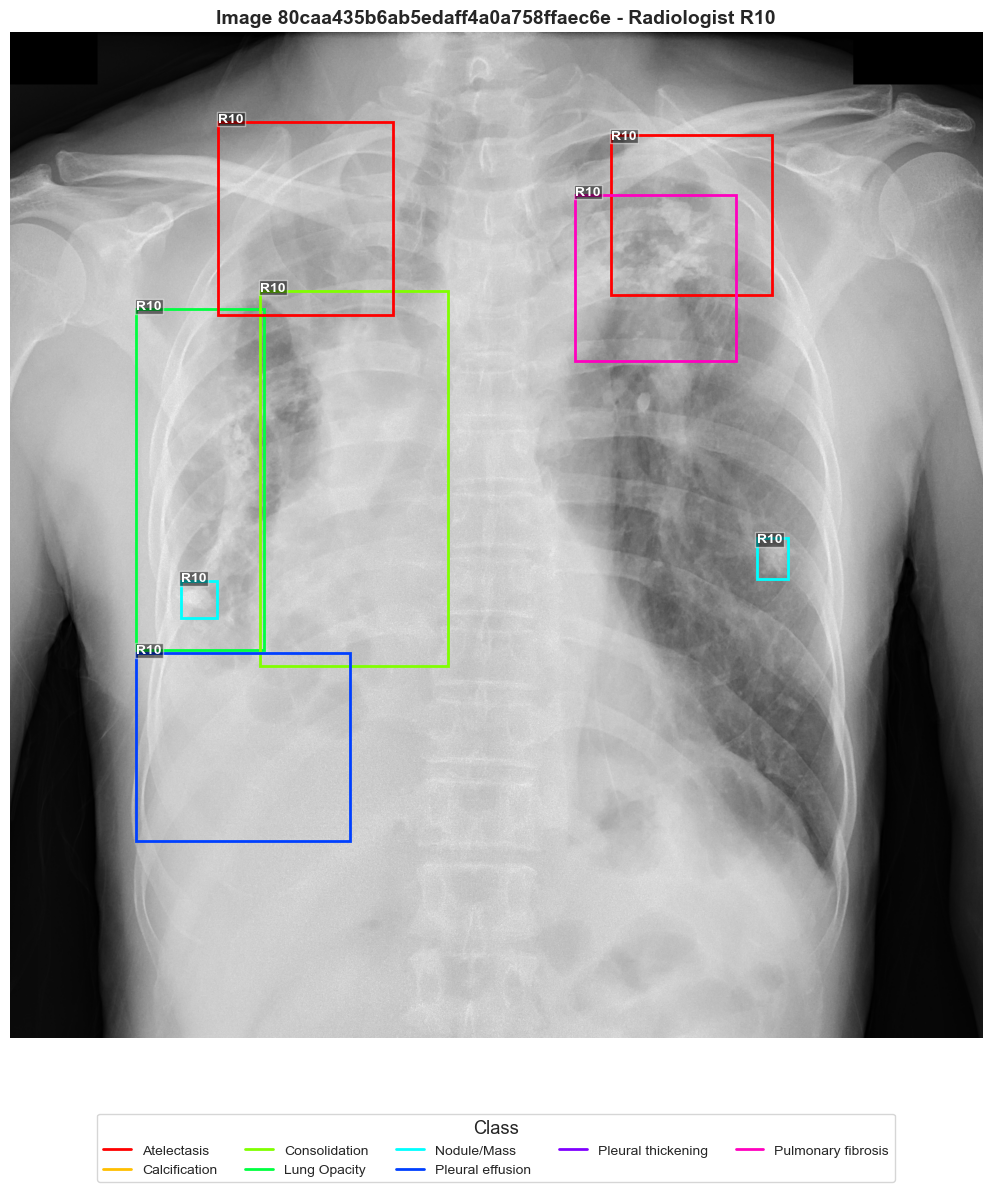

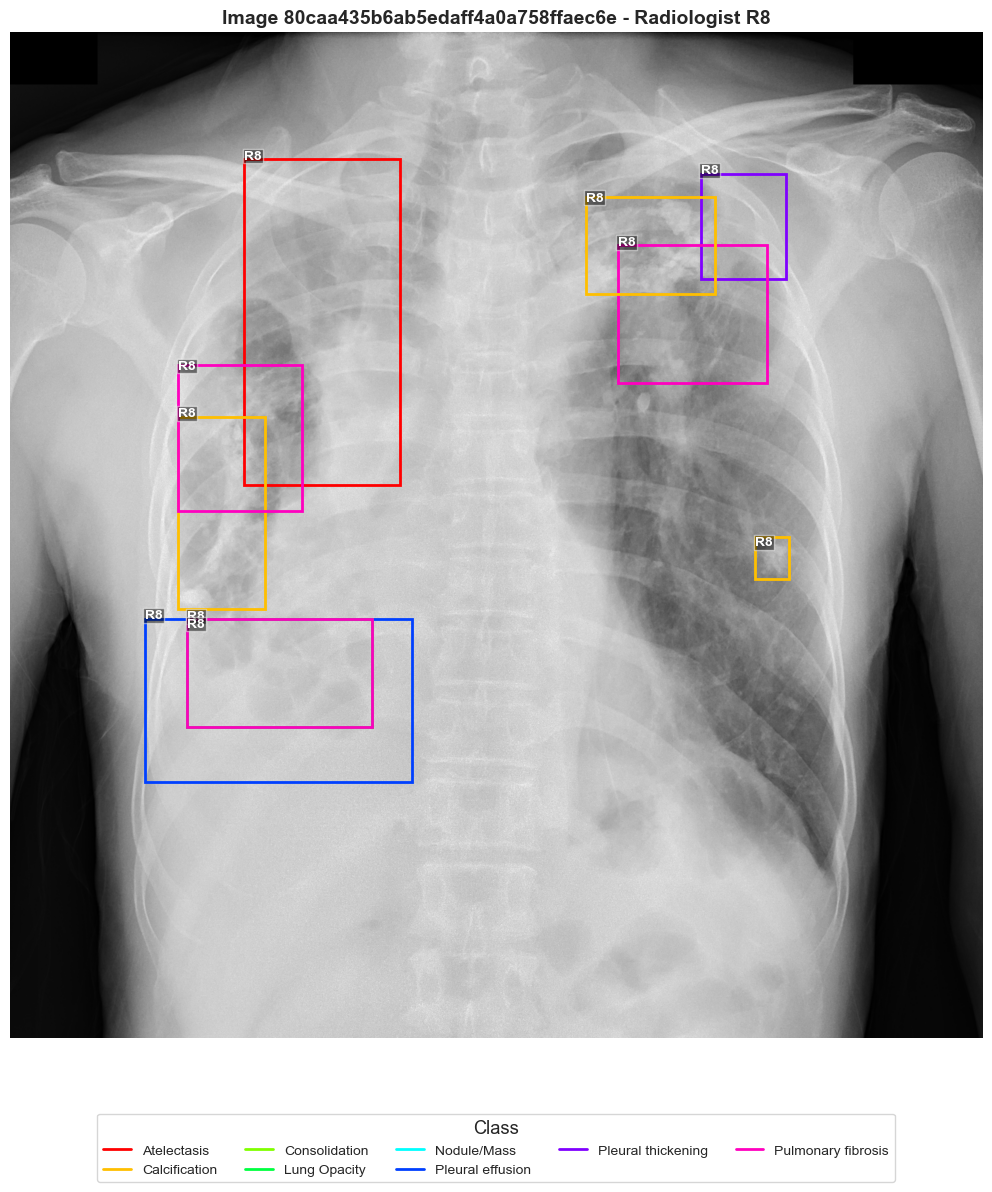

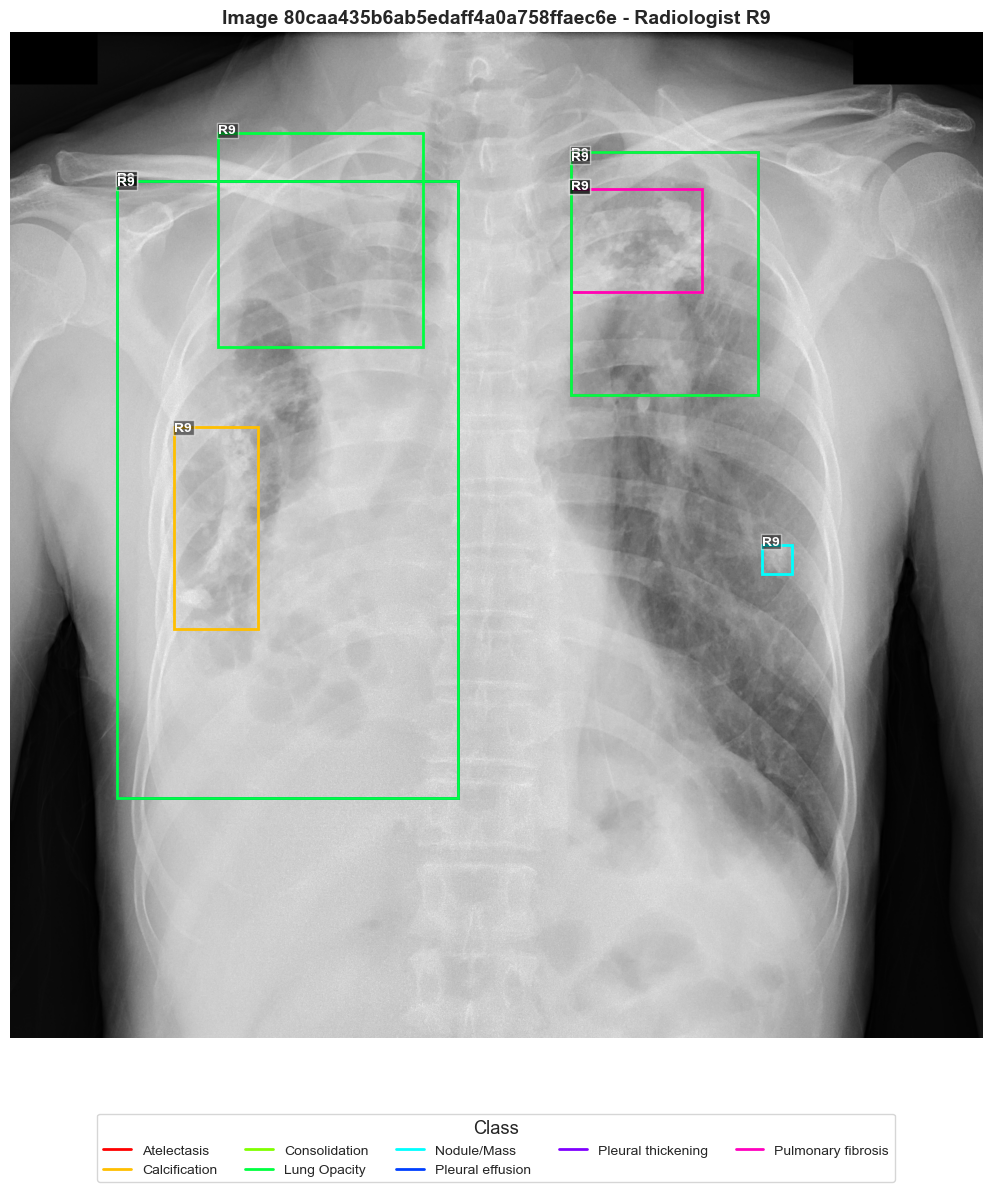

In [100]:
# =========================
# 2. Анализ согласованности радиологов
# =========================

# ----------------------
# Функция IoU (Intersection over Union)
# ----------------------
def iou(box1, box2):
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])
    inter_area = max(0, x2 - x1) * max(0, y2 - y1)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union_area = box1_area + box2_area - inter_area
    return inter_area / union_area if union_area > 0 else 0

# ----------------------
# Функции для чтения DICOM
# ----------------------
def read_dicom(path):
    dicom = pydicom.dcmread(path)
    data = dicom.pixel_array.astype(np.float32)
    slope = float(dicom.get("RescaleSlope", 1.0))
    intercept = float(dicom.get("RescaleIntercept", 0.0))
    data = data * slope + intercept
    if dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.max(data) - data
    data = data - np.min(data)
    data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    data_rgb = np.stack([data]*3, axis=-1)
    return data_rgb

# ----------------------
# Визуализация: отдельное изображение для каждого радиолога
# ----------------------
def plot_dicom_per_radiologist(image, bboxes, title_prefix="Image", figsize=(16,12)):
    """
    Рисует отдельное изображение для каждого радиолога.
    - Цвет рамки зависит от класса.
    - Подпись — только радиолог на этом изображении.
    """
    class_names = sorted({b['class_name'] for b in bboxes})
    n_classes = len(class_names)
    class_colors = [hsv_to_rgb((i/n_classes, 1, 1)) for i in range(n_classes)]
    class_color_map = {cls: class_colors[i] for i, cls in enumerate(class_names)}

    rad_ids = sorted({b['rad_id'] for b in bboxes})

    for rad in rad_ids:
        fig, ax = plt.subplots(figsize=figsize)
        ax.imshow(image, cmap="gray")
        ax.axis('off')
        ax.set_title(f"{title_prefix} - Radiologist {rad}", fontsize=14, fontweight='bold')

        # смещение подписи по классу
        offset_dict = {cls:0 for cls in class_names}

        for b in bboxes:
            if b['rad_id'] != rad:
                continue
            if not np.isfinite([b['x_min'], b['y_min'], b['x_max'], b['y_max']]).all():
                continue
            # рамка класса
            rect = patches.Rectangle(
                (b['x_min'], b['y_min']),
                b['x_max'] - b['x_min'],
                b['y_max'] - b['y_min'],
                linewidth=2,
                edgecolor=class_color_map[b['class_name']],
                facecolor='none'
            )
            ax.add_patch(rect)
            # подпись
            ax.text(
                b['x_min'], b['y_min'] + offset_dict[b['class_name']],
                f"{rad}",
                color='white',  # подпись белая для лучшей видимости
                fontsize=10,
                fontweight='bold',
                bbox=dict(facecolor='black', alpha=0.5, pad=1)
            )
            offset_dict[b['class_name']] += 12

        # легенда классов
        class_handles = [Line2D([0],[0], color=color, lw=2, label=cls)
                         for cls,color in class_color_map.items()]
        ax.legend(handles=class_handles, title="Class", loc='lower center',
                  bbox_to_anchor=(0.5, -0.15), ncol=min(5, n_classes), fontsize=10)

        plt.tight_layout()
        plt.show()

# ----------------------
# Пример использования
# ----------------------
example_image_id = '80caa435b6ab5edaff4a0a758ffaec6e'
image_path = os.path.join(dicom_train_dir, f"{example_image_id}.dicom")

if os.path.exists(image_path):
    image = read_dicom(image_path)
    bboxes_example = df[df["image_id"] == example_image_id][
        ["x_min","y_min","x_max","y_max","class_name","rad_id"]
    ].to_dict('records')
    plot_dicom_per_radiologist(image, bboxes_example, title_prefix=f"Image {example_image_id}")
else:
    print("Файл не найден:", image_path)

In [114]:
# =========================
# 2.1. Анализ согласованности радиологов по IoU
# =========================
results = []

for (image_id, class_name), group in df.groupby(["image_id", "class_name"]):
    if class_name == "No finding":
        continue  
    bboxes = group[["rad_id","x_min","y_min","x_max","y_max"]].to_dict('records')
    
    # Для каждой пары радиологов
    for b1, b2 in itertools.combinations(bboxes, 2):
        iou_val = iou([b1['x_min'], b1['y_min'], b1['x_max'], b1['y_max']],
                      [b2['x_min'], b2['y_min'], b2['x_max'], b2['y_max']])
        results.append({
            "image_id": image_id,
            "class_name": class_name,
            "rad1": b1['rad_id'],
            "rad2": b2['rad_id'],
            "iou": iou_val
        })

iou_df = pd.DataFrame(results)

# ----------------------
# Согласованность по радиологу
# ----------------------
rad_consistency = iou_df.groupby("rad1")["iou"].mean().reset_index()
rad_consistency = rad_consistency.rename(columns={"rad1":"rad_id", "iou":"mean_iou_with_others"})
rad_consistency = rad_consistency.sort_values("mean_iou_with_others", ascending=False).reset_index(drop=True)

print("Согласованность радиологов:")
display(rad_consistency)

# ----------------------
# Согласованность по классу
# ----------------------
class_consistency = iou_df.groupby("class_name")["iou"].mean().reset_index()
class_consistency = class_consistency.rename(columns={"iou":"mean_iou"})
class_consistency = class_consistency.sort_values("mean_iou", ascending=False).reset_index(drop=True)

print("Средняя согласованность по классам:")
display(class_consistency)

# ----------------------
# Общая согласованность
# ----------------------
overall_consistency = iou_df["iou"].mean()
print(f"Общая средняя согласованность всех радиологов и классов: {overall_consistency:.3f}")

Согласованность радиологов:


rad_id  mean_iou_with_others
0     R12              0.331634
1     R10              0.310664
2     R11              0.276707
3      R9              0.271498
4     R15              0.257669
5      R8              0.256677
6     R16              0.249935
7     R17              0.241638
8     R14              0.237609
9     R13              0.233677
10     R2              0.000000

Средняя согласованность по классам:


class_name  mean_iou
0         Cardiomegaly  0.728018
1   Aortic enlargement  0.683545
2         Pneumothorax  0.464739
3          Atelectasis  0.424206
4        Consolidation  0.395106
5     Pleural effusion  0.331663
6         Infiltration  0.259906
7         Lung Opacity  0.238240
8                  ILD  0.215356
9   Pulmonary fibrosis  0.204193
10       Calcification  0.145938
11  Pleural thickening  0.144157
12        Other lesion  0.133261
13         Nodule/Mass  0.064751

Общая средняя согласованность всех радиологов и классов: 0.277


In [118]:
# =========================
# 2.2. Бинарная согласованность радиологов (если есть пересечение, не важно какое по площади, результаты согласованы)
# =========================
results_binary = []

for (image_id, class_name), group in df.groupby(["image_id", "class_name"]):
    if class_name == "No finding":
        continue
    bboxes = group[["rad_id","x_min","y_min","x_max","y_max"]].to_dict('records')
    
    # Для каждой пары радиологов
    for b1, b2 in itertools.combinations(bboxes, 2):
        iou_val = iou([b1['x_min'], b1['y_min'], b1['x_max'], b1['y_max']],
                      [b2['x_min'], b2['y_min'], b2['x_max'], b2['y_max']])
        results_binary.append({
            "image_id": image_id,
            "class_name": class_name,
            "rad1": b1['rad_id'],
            "rad2": b2['rad_id'],
            "agreed": int(iou_val > 0)  # бинарная метка
        })

binary_df = pd.DataFrame(results_binary)

# ----------------------
# Бинарная согласованность по радиологу
# ----------------------
rad_binary = binary_df.groupby("rad1")["agreed"].mean().reset_index()
rad_binary = rad_binary.rename(columns={"rad1":"rad_id", "agreed":"mean_agreement_with_others"})
rad_binary = rad_binary.sort_values("mean_agreement_with_others", ascending=False).reset_index(drop=True)

print("Бинарная согласованность радиологов:")
display(rad_binary)

# ----------------------
# Бинарная согласованность по классу
# ----------------------
class_binary = binary_df.groupby("class_name")["agreed"].mean().reset_index()
class_binary = class_binary.rename(columns={"agreed":"mean_agreement"})
class_binary = class_binary.sort_values("mean_agreement", ascending=False).reset_index(drop=True)

print("Бинарная согласованность по классам:")
display(class_binary)

# ----------------------
# Общая бинарная согласованность
# ----------------------
overall_binary = binary_df["agreed"].mean()
print(f"Общая бинарная согласованность всех радиологов и классов: {overall_binary:.3f}")

Бинарная согласованность радиологов:


rad_id  mean_agreement_with_others
0     R12                    0.677966
1     R11                    0.603175
2     R16                    0.573840
3     R17                    0.552239
4     R15                    0.545752
5     R10                    0.525524
6     R13                    0.505376
7      R9                    0.459245
8     R14                    0.452830
9      R8                    0.431907
10     R2                    0.000000

Бинарная согласованность по классам:


class_name  mean_agreement
0   Aortic enlargement        0.997605
1         Cardiomegaly        0.992128
2          Atelectasis        0.840336
3         Pneumothorax        0.694779
4        Consolidation        0.691275
5     Pleural effusion        0.655629
6         Lung Opacity        0.483173
7         Infiltration        0.438879
8   Pulmonary fibrosis        0.420886
9                  ILD        0.369389
10        Other lesion        0.317089
11  Pleural thickening        0.307692
12       Calcification        0.290119
13         Nodule/Mass        0.144752

Общая бинарная согласованность всех радиологов и классов: 0.472


Выбранное изображение с высокой согласованностью: e529c5465cafd94ee9a3b38f7267523a


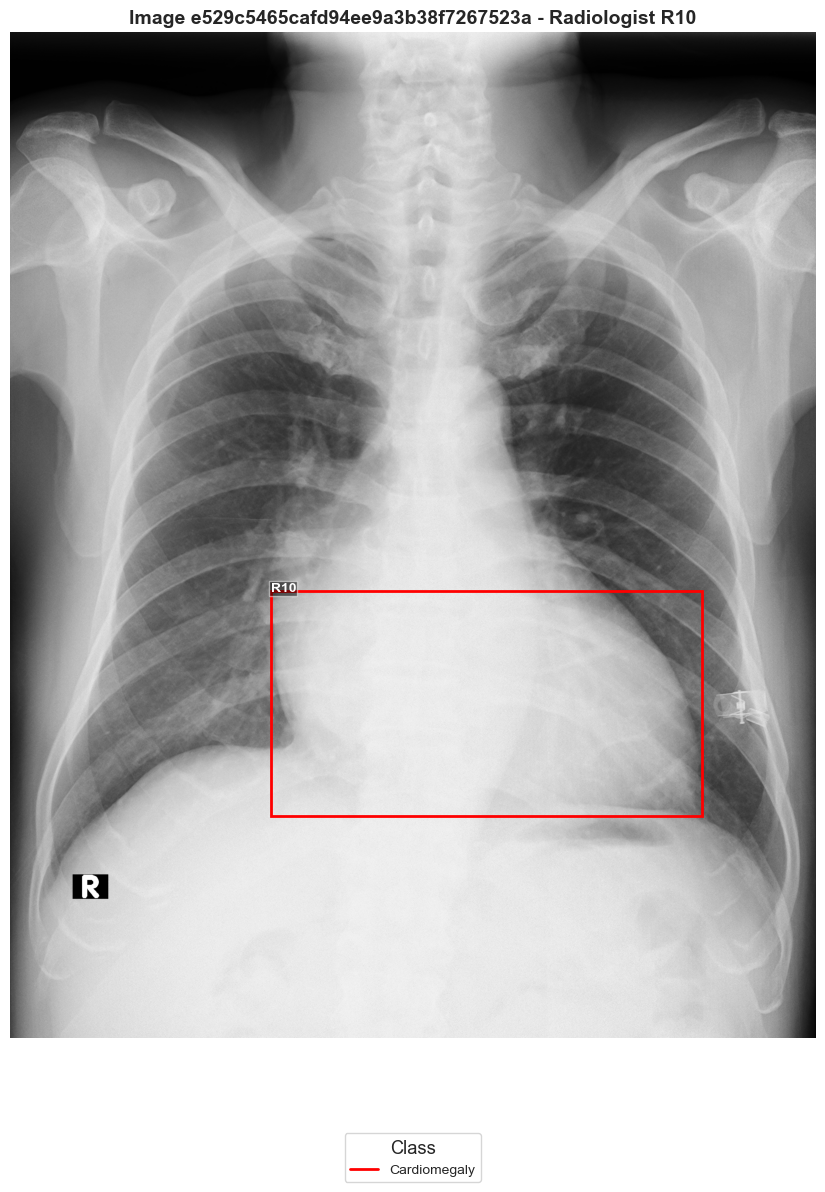

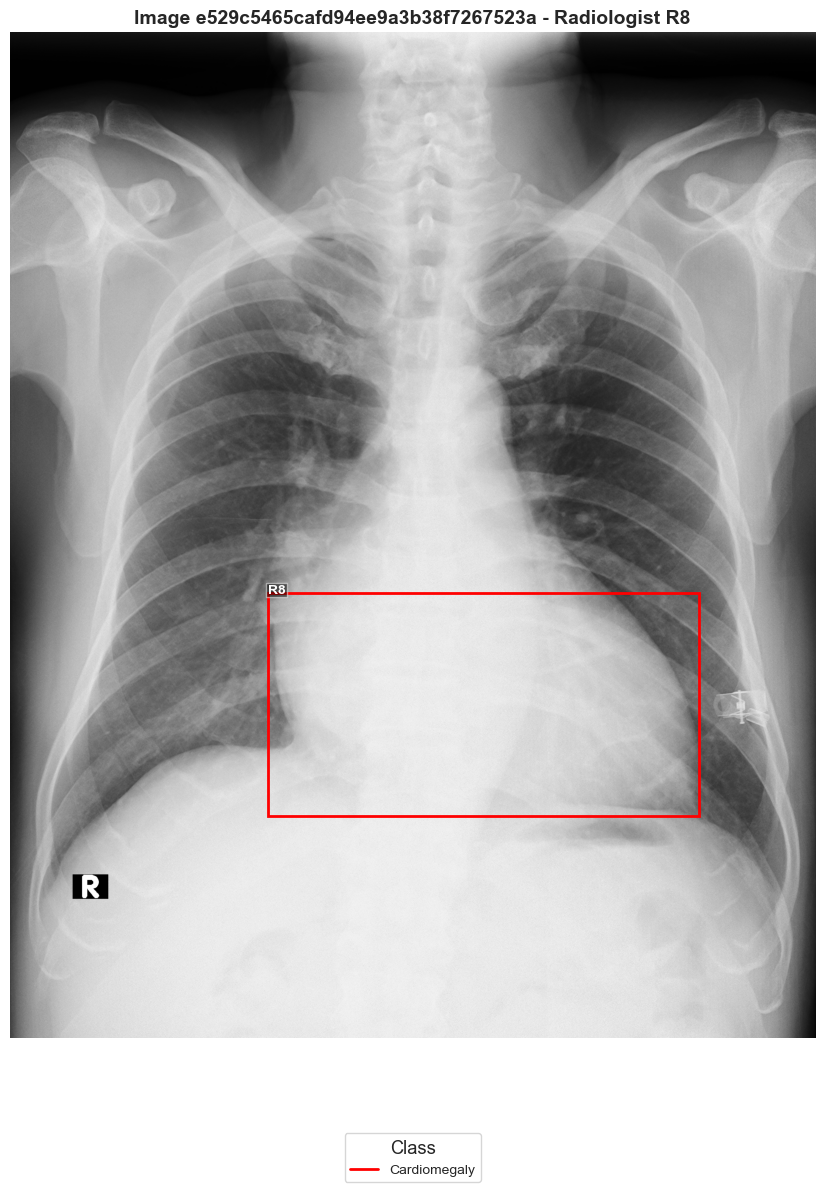

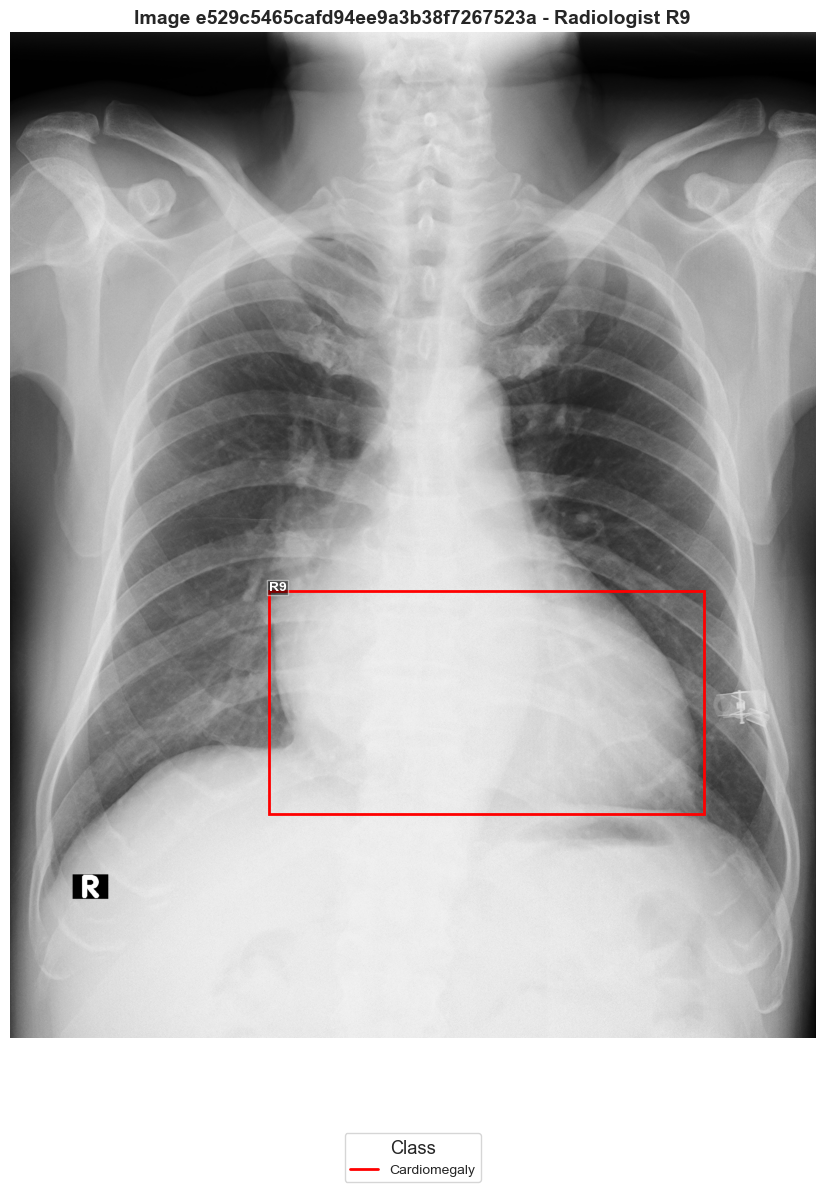

In [120]:
# ----------------------
# Выбираем image_id с высокой согласованностью
# ----------------------
image_iou_mean = iou_df.groupby("image_id")["iou"].mean().reset_index()
image_iou_mean = image_iou_mean.sort_values("iou", ascending=False).reset_index(drop=True)

# Берём top-1 изображение
example_image_id = image_iou_mean.loc[0, "image_id"]
print("Выбранное изображение с высокой согласованностью:", example_image_id)

# ----------------------
# 2. Путь к DICOM
# ----------------------
image_path = os.path.join(dicom_train_dir, f"{example_image_id}.dicom")

# ----------------------
# 3. Визуализация
# ----------------------
if os.path.exists(image_path):
    image = read_dicom(image_path)
    bboxes_example = df[df["image_id"] == example_image_id][
        ["x_min","y_min","x_max","y_max","class_name","rad_id"]
    ].to_dict('records')
    
    # Визуализация каждого радиолога на отдельном изображении
    plot_dicom_per_radiologist(image, bboxes_example, title_prefix=f"Image {example_image_id}")
else:
    print("Файл не найден:", image_path)


## VI. Зависимости и закономерности
***Проверим совместную встречаемость диагнозов, корелляции***

('Aortic enlargement', 'Cardiomegaly') - 709 изображений
('Aortic enlargement', 'Cardiomegaly', 'Pleural thickening') - 224 изображений
('Aortic enlargement', 'Cardiomegaly', 'Pulmonary fibrosis') - 75 изображений
('Aortic enlargement', 'Pleural thickening') - 69 изображений
('Aortic enlargement', 'Cardiomegaly', 'Other lesion') - 55 изображений
('Aortic enlargement', 'Cardiomegaly', 'Pleural effusion', 'Pleural thickening') - 51 изображений
('Pleural thickening', 'Pulmonary fibrosis') - 50 изображений
('Aortic enlargement', 'Cardiomegaly', 'Pleural thickening', 'Pulmonary fibrosis') - 41 изображений
('Aortic enlargement', 'Cardiomegaly', 'Lung Opacity') - 39 изображений
('Aortic enlargement', 'Pulmonary fibrosis') - 38 изображений


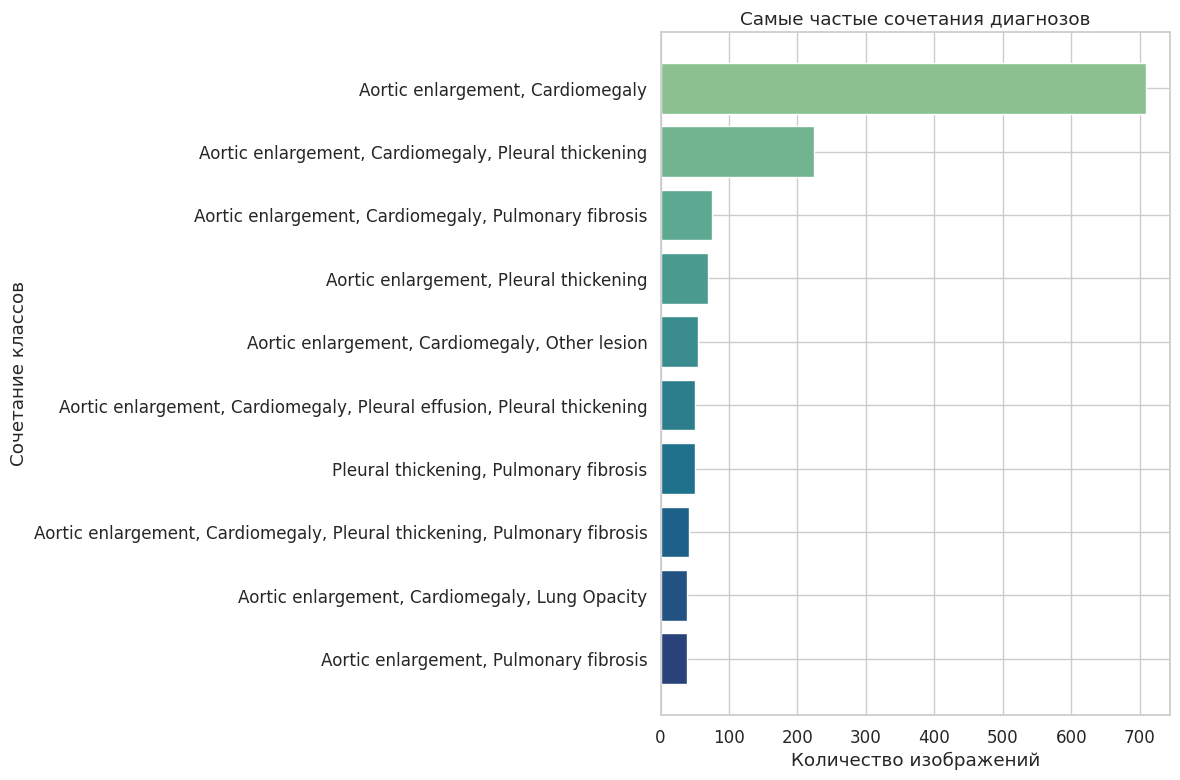

In [128]:
# Убираем "No finding"
df_no_nf = df[df["class_name"] != "No finding"].copy()

# Для каждого снимка собираем диагнозы, отсортированные по имени
class_combinations = (
    df_no_nf.groupby("image_id")["class_name"]
    .agg(lambda x: tuple(sorted(x.unique())))
)

# Сколько раз встретилась каждая комбинация
class_combination_counts = (
    class_combinations.value_counts()
    .reset_index()
)

class_combination_counts.columns = ["combination", "count"]

class_combination_counts["num_classes"] = class_combination_counts["combination"].apply(len)

# >= 2 диагнозов
class_combination_counts = class_combination_counts[class_combination_counts["num_classes"] >= 2]

top_class_combinations = class_combination_counts.head(10)

for idx, row in top_class_combinations.iterrows():
    print(f"{row['combination']} - {row['count']} изображений")

plt.figure(figsize=(12, 8))
plt.barh(
    [", ".join(comb) for comb in top_class_combinations["combination"]],
    top_class_combinations["count"],
    color=sns.color_palette("crest", len(top_class_combinations))
)
plt.xlabel("Количество изображений")
plt.ylabel("Сочетание классов")
plt.title("Самые частые сочетания диагнозов")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


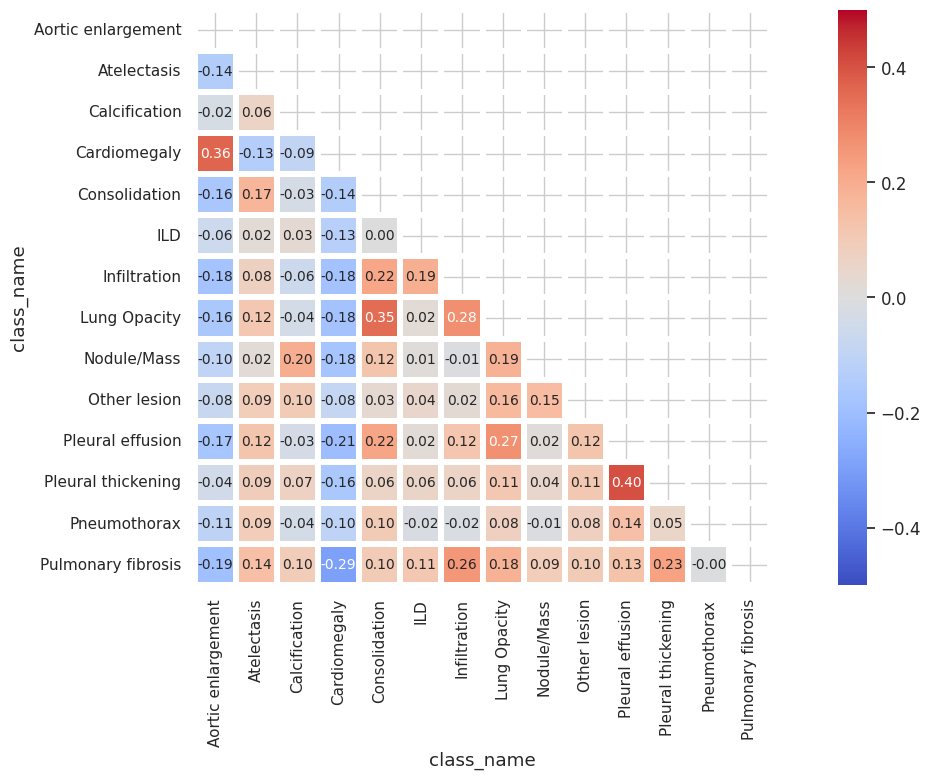

In [129]:
# Убираем "No finding"
df_no_nf = df[df["class_name"] != "No finding"].copy()

class_presence = (
    pd.crosstab(df_no_nf["image_id"], df_no_nf["class_name"])
    .clip(upper=1)
)

# Корреляция между классами
class_corr = class_presence.corr()

# Треугольник
fig, ax = plt.subplots(1, 1, figsize=(14, 8))

mask = np.zeros_like(class_corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

cmap = sns.color_palette("coolwarm", as_cmap=True)

sns.heatmap(
    class_corr,
    annot=True,
    fmt=".2f",
    square=True,
    mask=mask,
    linewidth=3,
    vmax=0.5, vmin=-0.5,
    cmap=cmap,
    cbar=True,
    ax=ax,
    annot_kws={"size": 10}
)


ax.set_yticklabels(ax.get_xticklabels(), rotation=0, fontsize=11)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=11)

plt.tight_layout()
plt.show()


## Вывод по анализу

### Общая информация

- **Уникальных снимков:** 15 000  
- **Уникальных радиологов:** 17  
- **Среднее количество разметок на снимок:** 4.53  
- **Медиана количества разметок на снимок:** 3  
- **Максимум разметок на одном снимке:** 57  
- **Медиана числа классов на снимок:** 1  
- **Максимальное число классов на снимок:** 10  

**Дисбаланс классов:**

- Почти 41% снимков — "No finding"  
- Редкие патологии встречаются менее чем на 1% снимков  
- Некоторые патологии встречаются чаще:  
  - Aortic enlargement — 11.8%  
  - Cardiomegaly — 8.9%  
  - Pleural thickening — 7.6%  

**Разметка по радиологам:**

- R9, R10, R8 сделали более 50% всех разметок  
- R17 сделал всего 812 разметок (1.2%)  

---

### Согласованность радиологов

#### По IoU

- **Средняя согласованность по радиологу:**  
  - Лучшие: R12, R10, R11 (~0.28–0.33)  
  - Худшие: R2 (0)  
- **Средняя согласованность по классам:**  
  - Наиболее согласованные: Cardiomegaly (0.73), Aortic enlargement (0.68)  
  - Менее согласованные: Nodule/Mass (~ 0.065), Other lesion (~ 0.13)  
- **Общая средняя согласованность:** 0.277  

#### Бинарная согласованность (наличие пересечения рамок)

- **Средняя бинарная согласованность по радиологу:**  
  - Лучшие: R12, R11, R16 (~0.55–0.68)  
  - Худшие: R2 (0)  
- **Средняя бинарная согласованность по классам:**  
  - Наиболее согласованные: Aortic enlargement (0.998), Cardiomegaly (0.992)  
  - Менее согласованные: Nodule/Mass (0.145), Calcification (0.29)  
- **Общая бинарная согласованность:** 0.472  

---

### Корреляции между патологиями

- Часто встречающиеся комбинации:  
  - Cardiomegaly + Aortic enlargement — 709 снимков  
  - Cardiomegaly + Aortic enlargement + Pleural thickening — 224 снимка  
  - Cardiomegaly + Aortic enlargement + Pulmonary fibrosis — 75 снимков  
- Выявленные коэффициенты корреляции:  
  - Pleural thickening & Pleural effusion — 0.40 
  - Cardiomegaly & Aortic enlargement — 0.36   
  - Lung Opacity & Consolidation — 0.35  

---

### Практические выводы для моделирования

1. **Учёт мультиклассовости:** модели должны уметь предсказывать несколько патологий одновременно.  
2. **Стратегии борьбы с дисбалансом:**  
   - Для классических ML — oversampling редких классов  
   - Для DL — weighted loss и data augmentation  
3. **Метрики:**  
   - Recall (важно не пропустить патологию)  
   - F1-score (macro и weighted)  
   - PR-AUC  
   - mAP (mean Average Precision)  
4. **Корреляции между патологиями:** можно использовать для feature engineering или постобработки DL-предсказаний  
5. **Согласованность разметки:** для классов с высокой вариативностью (низкая IoU) стоит учитывать неопределённость и, при необходимости, использовать ансамбли или вероятностные модели.
